# Import statements

In [1]:
from time import sleep
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np

from IPython import display

from labdrivers.srs import sr830
from labdrivers.keithley import keithley2400
from labdrivers.ni import nidaq

%matplotlib inline

# Experimental parameters

In [2]:
ac_div = 1062.7 * 10
dc_div = 533.9
preamp_sensitivity = 1e-6
line_resistance = 4000

quantum_g = 7.748091723083037e-05

# Calculators for values to use in bias/gate

Need to figure out what numbers to use as the min and max? Type the amount of whatever unit you'd like to apply across the device under test, and you should see how much you should use for ```(whatever)_min``` and ```(whatever)_max```.

In [7]:
desired_start = -2e-6
desired_finish = 2e-6

divider = ac_div

print('Start: {}'.format(desired_start * divider))
print('Finish: {}'.format(desired_finish * divider))

Start: -0.021254
Finish: 0.021254


# Instrument setup

## Lock-In

In [3]:
lockin = sr830(8)
lockin.enable_remote()

lockin.frequency = 84.41
lockin.input = 1
lockin.amplitude = 1

## DAQ

In [4]:
bias = nidaq()

## Gate

In [5]:
gate = keithley2400(22)
gate.enable_remote()

gate.source_type = 'voltage'
gate.source_mode = 'fixed'

gate.current_compliance = 2e-6

gate.measure_type = 'resistance'
gate.resistance_ohms_mode = 'manual'

# Experiments

### Bias parameters

In [15]:
bias_min = -1
bias_max = 1
num_data_points = 3

bias_voltages = np.linspace(start=bias_min, stop=bias_max, num=num_data_points)

### Gate parameters

In [16]:
gate_min = 0
gate_max = 1
num_data_points = 10

gate_voltages = np.linspace(start=gate_min, stop=gate_max, num=num_data_points)

## Bias sweep

In [10]:
file_name = 'test_sweep.txt'
comments = '''(insert comment here)'''

if exists(file_name):
    if str(input('Replace file? ')) == 'y':
        print('Overwriting "{}".'.format(file_name))
        
with open(file_name, 'w') as f:

    f.write('Comments\n')
    f.write('{}\n'.format(comments))
    f.write('bias_voltage,dI,dV,line+device_dI/dV,device_dI/dV\n')
    f.write('V,A,V,S,2e^2/h\n')

Replace file? y
Overwriting "test_sweep.txt".


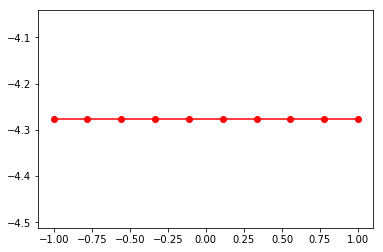

In [11]:
# Initialize the bias then wait for the device to respond and settle
bias.channel = 'ao1'
bias.output_voltage(bias_voltages[0])
sleep(4)

x = np.array([])
y = np.array([])

for bv in bias_voltages:

    bias.output_voltage(bv)
    sleep(0)

    current = lockin.single_output(1)[0] * preamp_sensitivity
    conductance = current / (lockin.amplitude / ac_div - current * line_resistance) / quantum_g

    x = np.append(x,bv)
    y = np.append(y,conductance)
    
    # Real-time plotting
    plt.clf()
    plt.plot(x,y,'r-o')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    with open(file_name, 'a') as f:
        f.write('{},{},{},{},{}\n'.format(-bv / dc_div, current, lockin.amplitude / ac_div, current / (lockin.amplitude / ac_div), conductance))



## 2D Gate-Bias Sweep

In [18]:
file_name = 'test_sweep.txt'
comments = '''(insert comment here)'''

if exists(file_name):
    if str(input('Replace file? ')) == 'y':
        print('Overwriting "{}".'.format(file_name))
        
with open(file_name, 'w') as f:

    f.write('Comments\n')
    f.write('{}\n'.format(comments))
    f.write('bias,gate,dI,dV,line+device_dI/dV,device_dI/dV\n')
    f.write('V,V,A,V,S,2e^2/h\n')

Replace file? y
Overwriting "test_sweep.txt".


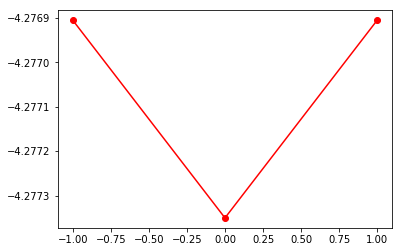

In [19]:
gate.output = 1
gate.source_type = 'voltage'

for gv in gate_voltages:

    # set gate and let settle

    gate.source_value = gv

    bias.channel = 'ao1'
    bias.output_voltage(bias_voltages[0])

    sleep(3)

    x = np.array([])
    y = np.array([])

    for bv in bias_voltages:

        bias.output_voltage(bv)
        sleep(0.9)

        current = lockin.single_output(1)[0] * preamp_sensitivity
        line_voltage = lockin.amplitude / ac_div
        line_conductance = current / line_voltage
        conductance = current / (line_voltage - current * line_resistance) / quantum_g

        x = np.append(x,bv)
        y = np.append(y,conductance)
        
        # Real-time plotting
        plt.clf()
        plt.plot(x,y,'r-o')
        display.display(plt.gcf())
        display.clear_output(wait=True)

        with open(file_name, 'a') as f:
            f.write('{},{},{},{},{},{}\n'.format(gv, -bv / dc_div, current, line_voltage, line_conductance, conductance))

## Gate Sweep

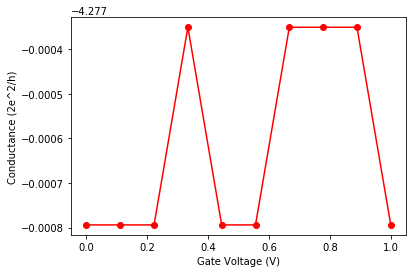

In [21]:
gate.output = 1
gate.source_type = 'voltage'

x = np.array([])
y = np.array([])

for gv in gate_voltages:
    
    gate.source_value = gv
    
    sleep(2)
    
    current = lockin.single_output(1)[0] * preamp_sensitivity
    line_voltage = lockin.amplitude / ac_div
    line_conductance = current / line_voltage
    conductance = current / (line_voltage - current * line_resistance) / quantum_g

    x = np.append(x,gv)
    y = np.append(y,conductance)

    # Real-time plotting
    plt.clf()
    plt.xlabel('Gate Voltage (V)')
    plt.ylabel('Conductance (2e^2/h)')
    plt.plot(x,y,'r-o')
    display.display(plt.gcf())
    display.clear_output(wait=True)

    with open(file_name, 'a') as f:
        f.write('{},{},{},{},{}\n'.format(gv, current, line_voltage, line_conductance, conductance))